In [1]:
# import tensorflow as tf
# resolver = tf.distribute.cluster_resolver.TPUClusterResolver()  
# tf.config.experimental_connect_to_cluster(resolver)  
# tf.tpu.experimental.initialize_tpu_system(resolver)  
# strategy = tf.distribute.TPUStrategy(resolver)  

In [2]:
import os
import numpy as np
import librosa
import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Conv2D, DepthwiseConv2D, BatchNormalization, ReLU, Add, Dense, GlobalAveragePooling2D, Input, Dropout, MaxPooling2D, AveragePooling2D, Concatenate




from sklearn.model_selection import train_test_split
import cv2

import matplotlib.pyplot as plt

In [3]:
path = "/kaggle/input/yasheen-khan/PCG_data"
categories = ['N', 'MR', 'MVP', 'AS', 'MS']
sample_file = "/kaggle/input/yasheen-khan/PCG_data/AS/New_AS_001.wav"
sr = 4000
n_fft = 2048
hop_length = 512
img_size = (128, 128)

def extract_stft(file):
    signal, _ = librosa.load(file, sr=sr)
    stft = librosa.stft(signal, n_fft=n_fft, hop_length=hop_length)
    spectrogram = librosa.amplitude_to_db(np.abs(stft))
    spectrogram = cv2.resize(spectrogram, img_size)
    spectrogram = np.stack([spectrogram] * 3, axis=-1)
    return np.array(spectrogram)

features = []
labels = []
for idx,lable in enumerate(categories):
    dir_ = f"{path}/{lable}/"
    for file in os.listdir(dir_):
        if file.endswith(".wav"):
            file = dir_+file
            features.append(extract_stft(file))
            labels.append(idx)

features = np.array(features, dtype="float32") / 255.0 
labels = np.array(labels)

X_train, X_test, y_train, y_test = train_test_split(features, labels, test_size=0.2, shuffle=True)
y_train = tf.keras.utils.to_categorical(y_train, num_classes=len(categories))
y_test = tf.keras.utils.to_categorical(y_test, num_classes=len(categories))

X_train.shape, y_train.shape, X_test.shape, y_test.shape




((800, 128, 128, 3), (800, 5), (200, 128, 128, 3), (200, 5))

# mobilenetv2

In [4]:
def inverted_residual_block(x, in_channels, out_channels, expansion, stride):

    expanded_channels = in_channels*expansion
    x = Conv2D(expanded_channels, (1,1), padding="same", use_bias=False)(x)
    x = BatchNormalization()(x)
    x = ReLU(6.0)(x)

    x = DepthwiseConv2D((3,3), strides=stride, padding="same", use_bias=False)(x)
    x = BatchNormalization()(x)
    x = ReLU(6.0)(x)
    x = Dropout(0.5)(x)

    x = Conv2D(out_channels, (1,1), padding="same", use_bias=False)(x)
    x = BatchNormalization()(x)

    if stride == 1 and in_channels == out_channels:
        x = Add()([x, input_tensor])

    return x

def build_mobilenetv2(input_shape=(128, 128, 3), num_classes=5):
    input_layer = Input(shape=input_shape)

    x = Conv2D(32, (3,3), strides=1, padding="same", use_bias=False)(input_layer)
    x = BatchNormalization()(x)
    x = ReLU(6.0)(x)

    x = inverted_residual_block(x, 32, 16, expansion=1, stride=1)
    x = inverted_residual_block(x, 16, 24, expansion=6, stride=2)
    x = inverted_residual_block(x, 24, 32, expansion=6, stride=1)
    x = inverted_residual_block(x, 32, 64, expansion=6, stride=2)
    x = inverted_residual_block(x, 64, 96, expansion=6, stride=1)
    x = inverted_residual_block(x, 96, 160, expansion=6, stride=1)
    x = inverted_residual_block(x, 160, 320, expansion=6, stride=1)

    x = GlobalAveragePooling2D()(x)

    x = Dense(128, activation="relu")(x)
    x = Dropout(0.5)(x)

    output_layer = Dense(num_classes, activation="softmax")(x)

    model = Model(inputs=input_layer, outputs=output_layer)

    return model

mobilenetv2 = build_mobilenetv2(input_shape=(128, 128, 3), num_classes=5)
mobilenetv2.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.01), loss="categorical_crossentropy", metrics=["accuracy"])


mobilenetv2.summary()


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)             │ (None, 128, 128, 3)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d (Conv2D)                      │ (None, 128, 128, 32)        │             864 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization                  │ (None, 128, 128, 32)        │             128 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ re_lu (ReLU)                         │ (None, 128, 128, 32)        │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_1 (Conv2D)                    │ (None, 128, 128, 32)        │           1,024 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_1                │ (None, 128, 128, 32)        │             128 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ re_lu_1 (ReLU)                       │ (None, 128, 128, 32)        │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ depthwise_conv2d (DepthwiseConv2D)   │ (None, 128, 128, 32)        │             288 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_2                │ (None, 128, 128, 32)        │             128 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ re_lu_2 (ReLU)                       │ (None, 128, 128, 32)        │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 128, 128, 32)        │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_2 (Conv2D)                    │ (None, 128, 128, 16)        │             512 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_3                │ (None, 128, 128, 16)        │              64 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_3 (Conv2D)                    │ (None, 128, 128, 96)        │           1,536 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_4                │ (None, 128, 128, 96)        │             384 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ re_lu_3 (ReLU)                       │ (None, 128, 128, 96)        │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ depthwise_conv2d_1 (DepthwiseConv2D) │ (None, 64, 64, 96)          │             864 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_5                │ (None, 64, 64, 96)          │             384 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼──────────────

 Total params: 787,669 (3.00 MB)

 Trainable params: 776,645 (2.96 MB)

 Non-trainable params: 11,024 (43.06 KB)

# DenseNet
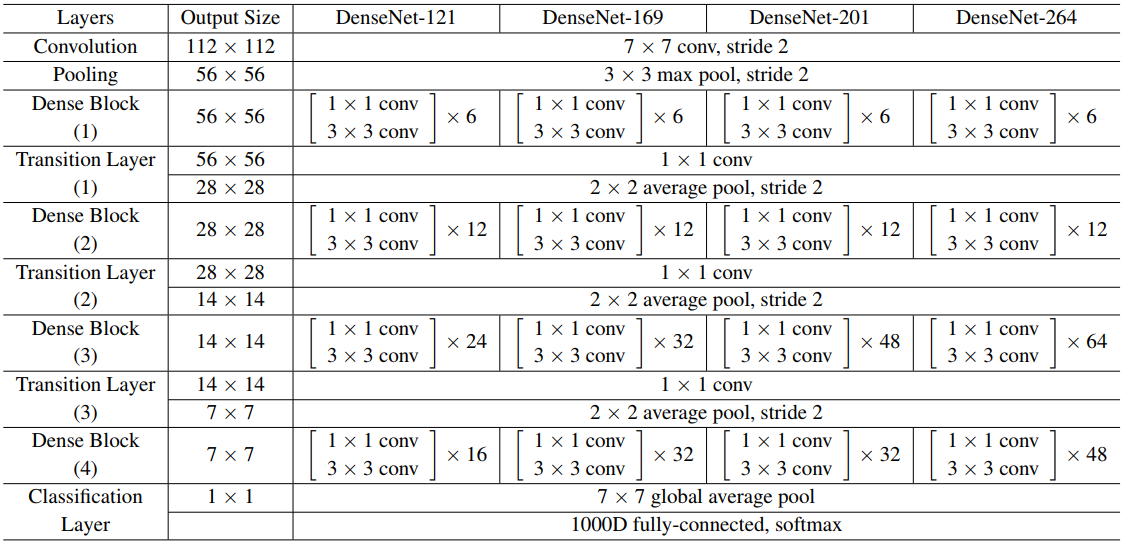
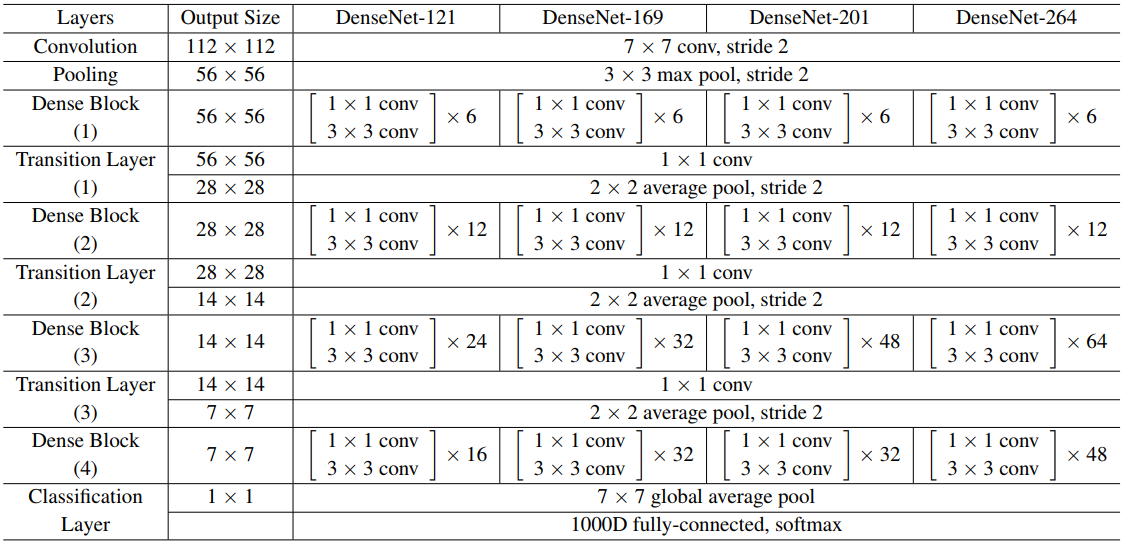

In [5]:
def dense_block(x, num_layers, growth_rate):
    for _ in range(num_layers):
        layer_input = x
        
        x = BatchNormalization()(x)
        x = ReLU()(x)
        x = Conv2D(4 * growth_rate, (1,1), padding="same", use_bias=False)(x)

        x = BatchNormalization()(x)
        x = ReLU()(x)
        x = Conv2D(growth_rate, (3,3), padding="same", use_bias=False)(x)
        x = Dropout(0.5)(x)
        x = Concatenate()([layer_input, x])
    return x


def transition_layer(x, compression_factor=0.5):
    filters = int(x.shape[-1] * compression_factor) 
    x = BatchNormalization()(x)
    x = ReLU()(x)
    x = Conv2D(filters, (1,1), padding="same", use_bias=False)(x)
    x = AveragePooling2D((2,2), strides=2, padding="same")(x)
    return x
    
def build_densenet201(input_shape=(128, 128, 3), num_classes=5, growth_rate=32):
    input_layer = Input(shape=input_shape)

    x = Conv2D(64, (7,7), strides=2, padding="same", use_bias=False)(input_layer)
    x = BatchNormalization()(x)
    x = ReLU()(x)
    x = MaxPooling2D((3,3), strides=2, padding="same")(x)

    x = dense_block(x, num_layers=6, growth_rate=growth_rate)
    x = transition_layer(x)

    x = dense_block(x, num_layers=12, growth_rate=growth_rate)
    x = transition_layer(x)

    x = dense_block(x, num_layers=24, growth_rate=growth_rate)
    x = transition_layer(x)

    x = dense_block(x, num_layers=16, growth_rate=growth_rate)

    x = BatchNormalization()(x)
    x = ReLU()(x)
    x = GlobalAveragePooling2D()(x)

    x = Dense(256, activation="relu")(x)
    x = Dropout(0.5)(x)

    output_layer = Dense(num_classes, activation="softmax")(x)

    model = Model(inputs=input_layer, outputs=output_layer)

    return model

# with strategy.scope():
densenet201 = build_densenet201(input_shape=(128, 128, 3), num_classes=5)
densenet201.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.01), loss="categorical_crossentropy", metrics=["accuracy"])
densenet201.summary()


Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer_1             │ (None, 128, 128, 3)    │              0 │ -                      │
│ (InputLayer)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_15 (Conv2D)        │ (None, 64, 64, 64)     │          9,408 │ input_layer_1[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_normalization_22    │ (None, 64, 64, 64)     │            256 │ conv2d_15[0][0]        │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ re_lu_15 (ReLU)           │ (None, 64, 64, 64)     │              0 │ batch_normalization_2… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ max_pooling2d             │ (None, 32, 32, 64)     │              0 │ re_lu_15[0][0]         │
│ (MaxPooling2D)            │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_normalization_23    │ (None, 32, 32, 64)     │            256 │ max_pooling2d[0][0]    │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ re_lu_16 (ReLU)           │ (None, 32, 32, 64)     │              0 │ batch_normalization_2… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_16 (Conv2D)        │ (None, 32, 32, 128)    │          8,192 │ re_lu_16[0][0]         │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_normalization_24    │ (None, 32, 32, 128)    │            512 │ conv2d_16[0][0]        │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ re_lu_17 (ReLU)           │ (None, 32, 32, 128)    │              0 │ batch_normalization_2… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_17 (Conv2D)        │ (None, 32, 32, 32)     │         36,864 │ re_lu_17[0][0]         │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dropout_8 (Dropout)       │ (None, 32, 32, 32)     │              0 │ conv2d_17[0][0]        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ concatenate (Concatenate) │ (None, 32, 32, 96)     │              0 │ max_pooling2d[0][0],   │
│                           │                        │                │ dropout_8[0][0]        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_normalization_25    │ (None, 32, 32, 96)     │            384 │ concatenate[0][0]      │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ re_lu_18 (ReLU)           │ (None, 32, 32, 96)     │              0 │ batch_normalization_2… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_18 (Conv2D)        │ (None, 32, 32, 128)    │         12,288 │ re_lu_18[0][0]         │
├──────────────────────

 Total params: 7,301,189 (27.85 MB)

 Trainable params: 7,217,541 (27.53 MB)

 Non-trainable params: 83,648 (326.75 KB)

In [6]:
mobilenetv2.fit(X_train, y_train, 
                    epochs=10, 
                    batch_size=16, 
                    validation_data=(X_test, y_test))

Epoch 1/10
50/50 ━━━━━━━━━━━━━━━━━━━━ 40s 178ms/step - accuracy: 0.3340 - loss: 1.6436 - val_accuracy: 0.2150 - val_loss: 3.3823
Epoch 2/10
50/50 ━━━━━━━━━━━━━━━━━━━━ 4s 82ms/step - accuracy: 0.5813 - loss: 0.9977 - val_accuracy: 0.1750 - val_loss: 9.7721
Epoch 3/10
50/50 ━━━━━━━━━━━━━━━━━━━━ 4s 82ms/step - accuracy: 0.6542 - loss: 0.8414 - val_accuracy: 0.1750 - val_loss: 11.2363
Epoch 4/10
50/50 ━━━━━━━━━━━━━━━━━━━━ 4s 82ms/step - accuracy: 0.7097 - loss: 0.7650 - val_accuracy: 0.1750 - val_loss: 13.9666
Epoch 5/10
50/50 ━━━━━━━━━━━━━━━━━━━━ 4s 83ms/step - accuracy: 0.7107 - loss: 0.7661 - val_accuracy: 0.1750 - val_loss: 16.7535
Epoch 6/10
50/50 ━━━━━━━━━━━━━━━━━━━━ 4s 83ms/step - accuracy: 0.7520 - loss: 0.7020 - val_accuracy: 0.3050 - val_loss: 7.6821
Epoch 7/10
50/50 ━━━━━━━━━━━━━━━━━━━━ 4s 84ms/step - accuracy: 0.7270 - loss: 0.7375 - val_accuracy: 0.4650 - val_loss: 2.8312
Epoch 8/10
50/50 ━━━━━━━━━━━━━━━━━━━━ 4s 84ms/step - accuracy: 0.7528 - loss: 0.6950 - val_accuracy: 0.225

In [7]:
densenet201.fit(X_train, y_train, 
                    epochs=10, 
                    batch_size=16, 
                    validation_data=(X_test, y_test))

Epoch 1/10
50/50 ━━━━━━━━━━━━━━━━━━━━ 175s 346ms/step - accuracy: 0.2238 - loss: 4.1391 - val_accuracy: 0.1600 - val_loss: 34011496.0000
Epoch 2/10
50/50 ━━━━━━━━━━━━━━━━━━━━ 4s 72ms/step - accuracy: 0.3766 - loss: 1.7440 - val_accuracy: 0.2350 - val_loss: 152.8974
Epoch 3/10
50/50 ━━━━━━━━━━━━━━━━━━━━ 4s 71ms/step - accuracy: 0.4433 - loss: 1.2472 - val_accuracy: 0.2900 - val_loss: 1.6827
Epoch 4/10
50/50 ━━━━━━━━━━━━━━━━━━━━ 4s 71ms/step - accuracy: 0.4831 - loss: 1.1225 - val_accuracy: 0.2800 - val_loss: 1.7611
Epoch 5/10
50/50 ━━━━━━━━━━━━━━━━━━━━ 4s 72ms/step - accuracy: 0.4679 - loss: 1.1577 - val_accuracy: 0.2450 - val_loss: 2.2756
Epoch 6/10
50/50 ━━━━━━━━━━━━━━━━━━━━ 4s 71ms/step - accuracy: 0.4837 - loss: 1.1242 - val_accuracy: 0.2900 - val_loss: 2.5637
Epoch 7/10
50/50 ━━━━━━━━━━━━━━━━━━━━ 4s 72ms/step - accuracy: 0.5450 - loss: 1.0169 - val_accuracy: 0.3600 - val_loss: 1.8708
Epoch 8/10
50/50 ━━━━━━━━━━━━━━━━━━━━ 4s 72ms/step - accuracy: 0.5164 - loss: 1.0421 - val_accuracy